# Важно

*Данный блокнот нужен лишь для визуализации процесса обучения модели, при попытке запуска данного блокнота вне Google Colaboratory некоторые важные функции не будут работать*

Результаты обучения сохраняются в удаленной директории https://drive.google.com/drive/u/1/folders/1_NoihxVVlRLWrg2ITqUT8zafuJpZFGgo в виде .h5 файла весов. Доступ к этим весам далее может быть получен с помощью функции lesa.models.utils.get_remote_weights_path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/mikhail-moro/lesa.git
!cp -a /content/lesa/benchmark.py /content/
!pip install livelossplot

Cloning into 'lesa'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 414 (delta 23), reused 29 (delta 7), pack-reused 352
Receiving objects: 100% (414/414), 40.86 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
import os
import datetime

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from benchmark import Benchmark
from livelossplot import PlotLosses


IMAGE_SIZE = 256
BATCH_SIZE = 16

AUTOTUNE = tf.data.AUTOTUNE
DATASETS_DIR = "/content/drive/MyDrive/datasets"

# Данные

In [ ]:
#@markdown Датасет
dataset_name = "auto" # @param {type:"string"}

if dataset_name == "auto":
    files_data = {}

    for dt in os.listdir(DATASETS_DIR):
        metadata_dir = os.path.join(DATASETS_DIR, dt, 'metadata.csv')

        if os.path.exists(metadata_dir):
            files_data[os.path.join(DATASETS_DIR, dt)] = datetime.datetime.strptime(
                pd.read_csv(metadata_dir)["time_create"][0],
                "%d-%m-%Y %H:%M"
            )

    DATASET_PATH = max(files_data, key=files_data.get) # Получаем последний созданный датасет
else:
    DATASET_PATH = dataset_name

dataset_metadata = pd.read_csv(os.path.join(DATASET_PATH, 'metadata.csv'))

dataset_metadata

train_files          val_files       time_create
0  file 1.tfrecords  file 10.tfrecords  05-10-2023 16:20
1  file 2.tfrecords                NaN               NaN
2  file 3.tfrecords                NaN               NaN
3  file 4.tfrecords                NaN               NaN
4  file 5.tfrecords                NaN               NaN
5  file 6.tfrecords                NaN               NaN
6  file 7.tfrecords                NaN               NaN
7  file 8.tfrecords                NaN               NaN
8  file 9.tfrecords                NaN               NaN

In [ ]:
!mkdir dataset
!cp -a "$DATASET_PATH/." /content/dataset/

In [ ]:
rescaling_layer = tf.keras.layers.Rescaling(1./255)

feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "mask": tf.io.FixedLenFeature([], tf.string)
}


@tf.function
def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.ensure_shape(tf.io.decode_jpeg(example["image"], channels=3), (IMAGE_SIZE, IMAGE_SIZE, 3))
    example["mask"] = tf.ensure_shape(tf.io.decode_jpeg(example["mask"], channels=1), (IMAGE_SIZE, IMAGE_SIZE, 1))
    return example

@tf.function
def prepare_tfrecord_fn(example):
    return rescaling_layer(example["image"]), rescaling_layer(example["mask"])


train_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["train_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(prepare_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(BATCH_SIZE*10)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["val_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(prepare_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(BATCH_SIZE*5)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
);

# Модель

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        num_filters: int = 256,
        kernel_size: int | tuple[int, int] = 3,
        dilation_rate: int = 1,
        dropout: float = 0.05,
        use_bias: bool = False,
    ):
        super().__init__()

        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout = dropout
        self.use_bias = use_bias

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            self.num_filters,
            kernel_size=self.kernel_size,
            dilation_rate=self.dilation_rate,
            use_bias=self.use_bias,
            padding='same',
            kernel_initializer=tf.keras.initializers.HeNormal(),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

        if self.dropout > 0.:
            self.use_dropout = True
            self.drop = tf.keras.layers.Dropout(self.dropout)
        else:
            self.use_dropout = False

        super().build(input_shape)

    def call(self, inputs, *args, **kwargs):
        conv = self.conv(inputs)
        conv = self.batch_norm(conv)
        conv = self.activation(conv)

        if self.use_dropout:
            conv = self.drop(conv)

        return conv


class EncoderBlock:
    def __init__(
        self,
        num_filters,
        use_pooling=True,
        dropout=0.05
    ):
        self.use_pooling = use_pooling

        self.conv_1 = ConvBlock(
            num_filters=num_filters,
            kernel_size=(3, 3),
            use_bias=False,
            dropout=dropout
        )

        self.conv_2 = ConvBlock(
            num_filters=num_filters,
            kernel_size=(3, 3),
            use_bias=False,
            dropout=dropout
        )

        if use_pooling:
            self.pooling = tf.keras.layers.MaxPooling2D((2, 2))

    def __call__(self, inputs):
        conv = self.conv_1(inputs)
        conv = self.conv_2(conv)

        if self.use_pooling:
            pool = self.pooling(conv)
        else:
            pool = None

        return conv, pool


class DecoderBlock:
    def __init__(
        self,
        num_filters,
        concatenate_with=None,
        dropout=0.05
    ):
        self.concatenate_with = concatenate_with if concatenate_with else []

        self.conv_transpose = tf.keras.layers.Conv2DTranspose(
            num_filters,
            (3, 3),
            padding='same',
            strides=(2, 2),
            kernel_initializer='he_normal',
            use_bias=False
        )
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.activation_1 = tf.keras.layers.ReLU()

        if dropout > 0.:
            self.use_dropout = True
            self.dropout = tf.keras.layers.Dropout(dropout)
        else:
            self.use_dropout = False

        self.weights_concat = tf.keras.layers.Concatenate()

        self.conv = ConvBlock(
            num_filters=num_filters,
            kernel_size=(3, 3),
            use_bias=False,
            dropout=dropout
        )

    def __call__(self, inputs):
        conv = self.conv_transpose(inputs)
        conv = self.batch_norm_1(conv)
        conv = self.activation_1(conv)

        if self.use_dropout:
            conv = self.dropout(conv)

        conv = self.weights_concat([conv, *self.concatenate_with])
        conv = self.conv(conv)

        return conv


class DSPP(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.av_pooling = tf.keras.layers.AveragePooling2D(pool_size=(input_shape[1], input_shape[2]))
        pool_out_shape = self.av_pooling.compute_output_shape(input_shape)

        self.conv = ConvBlock(kernel_size=1, use_bias=True)
        self.up_sampling = tf.keras.layers.UpSampling2D(
            size=(input_shape[1] // pool_out_shape[1], input_shape[2] // pool_out_shape[2]),
            interpolation="bilinear"
        )

        self.conv_1 = ConvBlock(kernel_size=1, dilation_rate=1)
        self.conv_6 = ConvBlock(kernel_size=3, dilation_rate=6)
        self.conv_12 = ConvBlock(kernel_size=3, dilation_rate=12)
        self.conv_18 = ConvBlock(kernel_size=3, dilation_rate=18)

        self.weights_concat = tf.keras.layers.Concatenate(axis=-1)
        self.final_conv = ConvBlock(kernel_size=1)

        super().build(input_shape)

    def call(self, inputs, *args, **kwargs):
        x = self.av_pooling(inputs)
        x = self.conv(x)

        out_pool = self.up_sampling(x)

        out_1 = self.conv_1(inputs)
        out_6 = self.conv_6(inputs)
        out_12 = self.conv_12(inputs)
        out_18 = self.conv_18(inputs)

        x = self.weights_concat([out_pool, out_1, out_6, out_12, out_18])
        output = self.final_conv(x)

        return output

In [ ]:
INPUT_SHAPE = (256, 256, 3)

model_input = tf.keras.layers.Input(INPUT_SHAPE)

resnet50 = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=model_input,
    input_shape=INPUT_SHAPE
)

x = resnet50.get_layer("conv4_block6_2_relu").output
x = DSPP()(x)

input_a = tf.keras.layers.UpSampling2D(
    size=(INPUT_SHAPE[0] // 4 // x.shape[1], INPUT_SHAPE[1] // 4 // x.shape[2]),
    interpolation="bilinear"
)(x)

input_b = resnet50.get_layer("conv2_block3_2_relu").output
input_b = ConvBlock(num_filters=128, kernel_size=1)(input_b)

x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
x = ConvBlock()(x)
x = ConvBlock()(x)
x = tf.keras.layers.UpSampling2D(
    size=(INPUT_SHAPE[0] // x.shape[1], INPUT_SHAPE[1] // x.shape[2]),
    interpolation="bilinear"
)(x)

model_output = tf.keras.layers.Conv2D(1, kernel_size=(1, 1), padding="same")(x)
model_output = tf.keras.layers.Activation('sigmoid')(model_output)

model = tf.keras.models.Model(inputs=[model_input], outputs=[model_output], name='ResNet50_DeepLabV3_plus')

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryIoU(),
        'accuracy'
    ]
);

94765736/94765736 [==============================] - 0s 0us/step


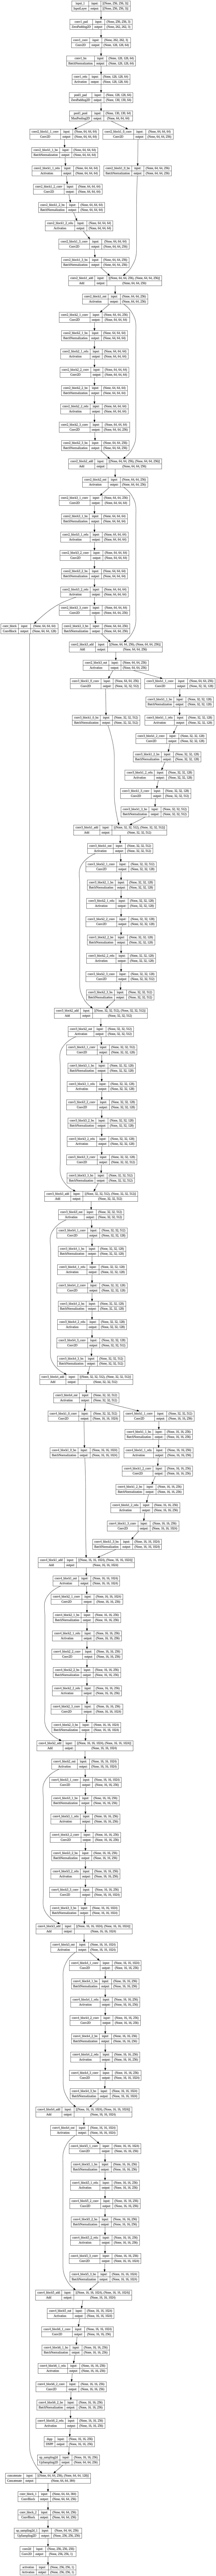

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True
)

# Обучение

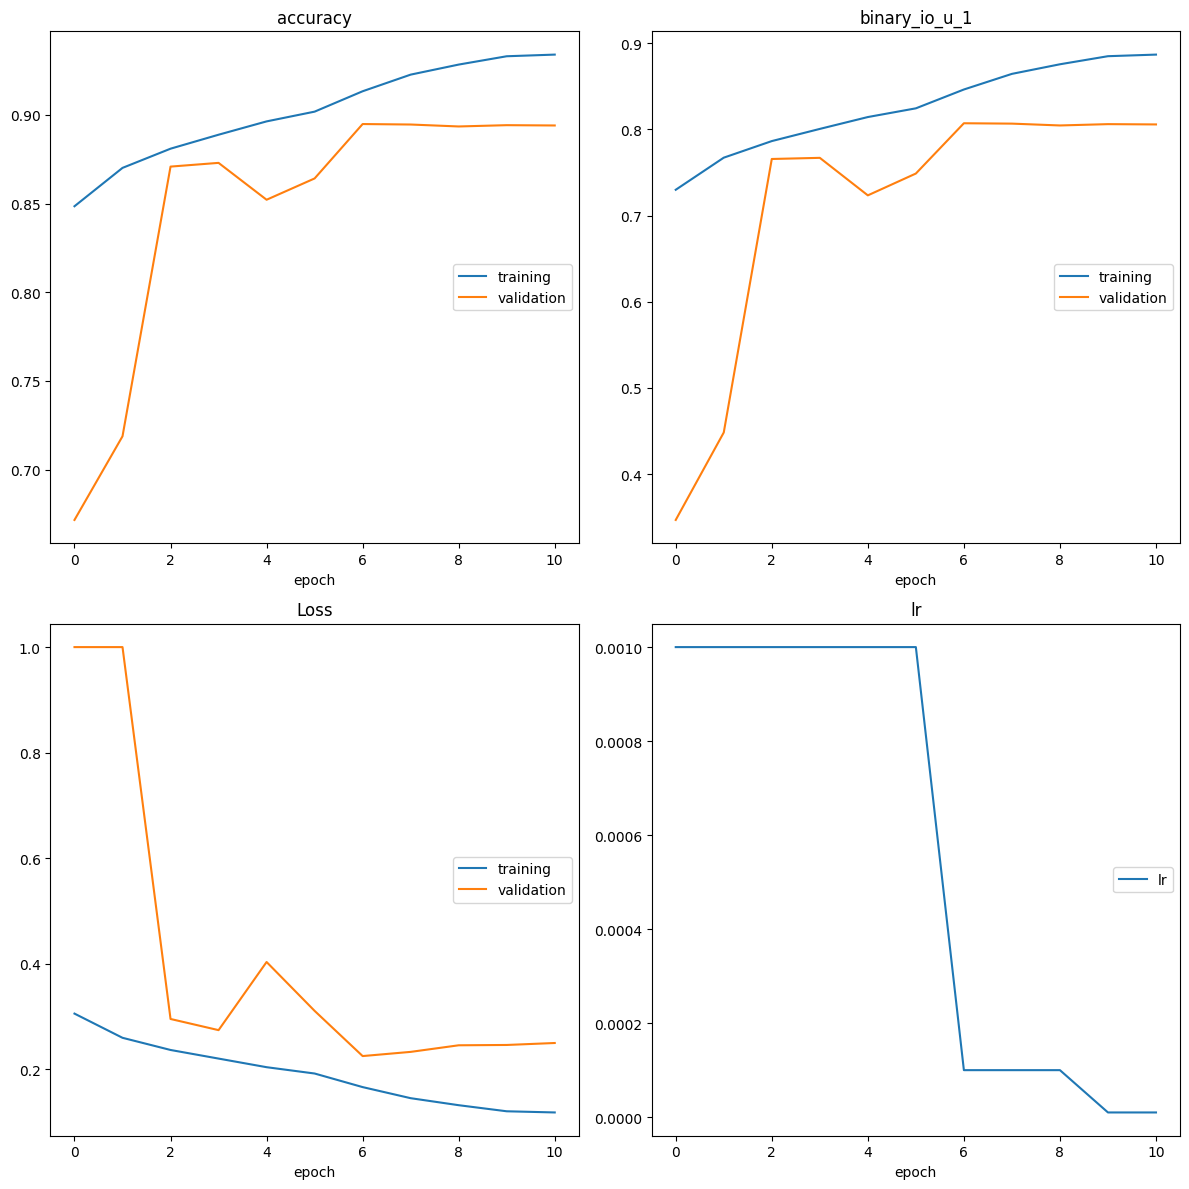

accuracy
	training         	 (min:    0.849, max:    0.934, cur:    0.934)
	validation       	 (min:    0.672, max:    0.895, cur:    0.894)
binary_io_u_1
	training         	 (min:    0.730, max:    0.887, cur:    0.887)
	validation       	 (min:    0.347, max:    0.807, cur:    0.806)
Loss
	training         	 (min:    0.118, max:    0.306, cur:    0.118)
	validation       	 (min:    0.225, max:    1.000, cur:    0.250)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
417/417 [==============================] - 164s 393ms/step - loss: 0.1184 - binary_io_u_1: 0.8868 - accuracy: 0.9340 - val_loss: 0.2500 - val_binary_io_u_1: 0.8058 - val_accuracy: 0.8940 - lr: 1.0000e-05
Epoch 11: early stopping


In [ ]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def __init__(self, clip: tuple = None, **kwargs):
        super().__init__()
        self.liveplot = PlotLosses(**kwargs)
        self.clip = clip

    def on_epoch_end(self, epoch, logs=None):
        limited_logs = logs.copy()

        if self.clip:
            for key, value in limited_logs.items():
                if value < self.clip[0]:
                    limited_logs[key] = self.clip[0]

                if value > self.clip[1]:
                    limited_logs[key] = self.clip[1]

        self.liveplot.update(limited_logs, epoch)
        self.liveplot.send()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    PlotLossesCallback(clip=(0, 1))
]

history = model.fit(
    x=train_dataset,
    batch_size=BATCH_SIZE,
    epochs=25,
    validation_data=val_dataset,
    callbacks=callbacks
)

In [ ]:
model.save_weights(f"/content/drive/MyDrive/lesa/weights/weights {model.name} {datetime.datetime.now()}.h5");

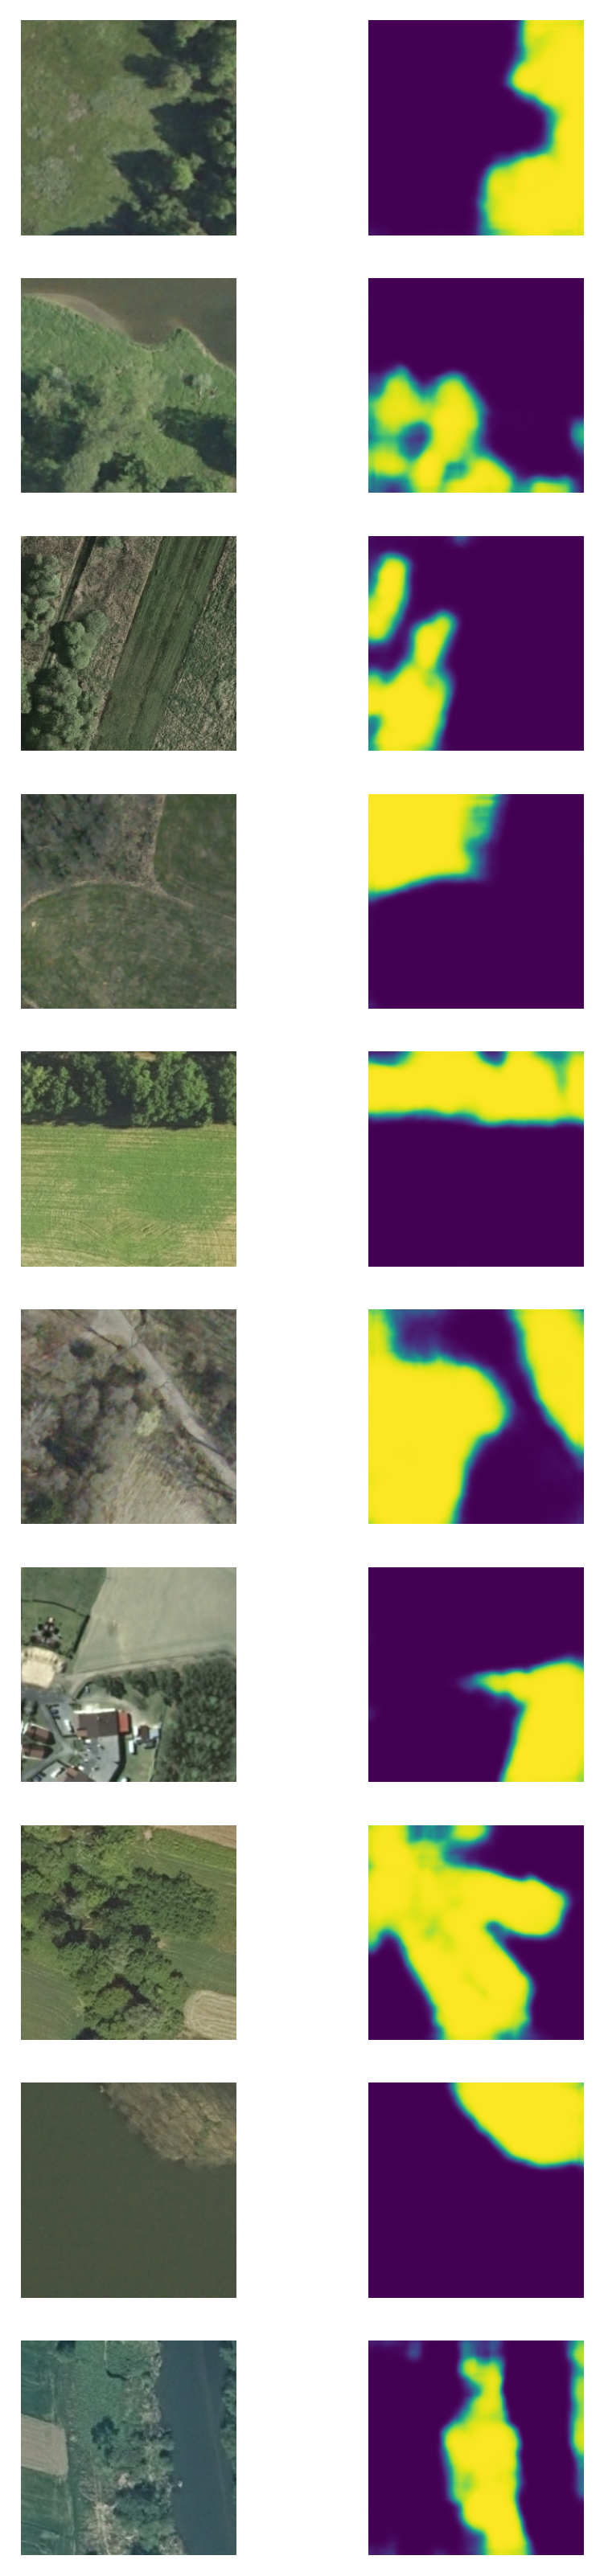

In [ ]:
examples = 10

test_dataset = (
    tf.data.TFRecordDataset(
        [os.path.join("/content/dataset", fl) for fl in dataset_metadata["train_files"].dropna()],
        num_parallel_reads=AUTOTUNE
    )
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)


fig = plt.figure(figsize=(4, 16), dpi=256)
ax_mat = fig.subplots(nrows=examples, ncols=2)
ax = ax_mat.flatten()
lst = list(test_dataset.take(10))


for i, l in zip(range(0, examples*2, 2), lst):
    example = rescaling_layer(l["image"])
    predicted = model.predict(np.array([example]), verbose=0)[0]

    ax[i].imshow(example)
    ax[i].set_axis_off()

    ax[i+1].imshow(predicted)
    ax[i+1].set_axis_off()


fig.show();

# Проверка на фото Ростова со спутника

In [ ]:
benchmark = Benchmark(
    save_for_visualising=True,
    images_path="/content/lesa/benchmark_data/images",
    masks_path="/content/lesa/benchmark_data/masks"
)

test_data = benchmark.compute(model)
images_data = benchmark.get_images_data()

pd.DataFrame(test_data.items())

0         1
0     mean_binary_io_u  0.702469
1  zoom_16_binary_io_u  0.627375
2  zoom_17_binary_io_u  0.734161
3  zoom_18_binary_io_u  0.745870

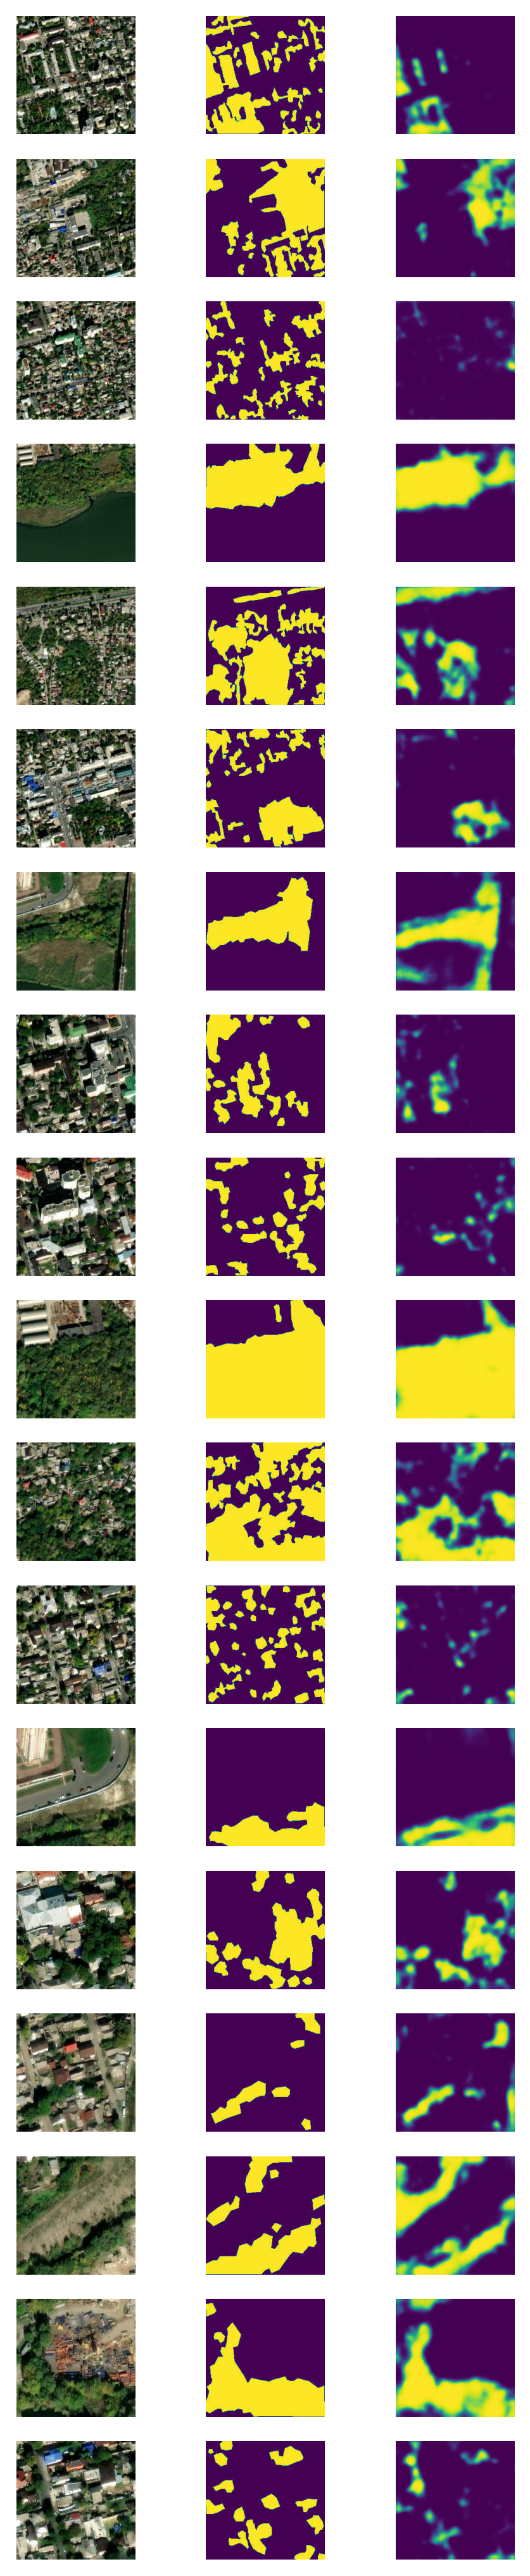

In [ ]:
fig, axis = plt.subplots(nrows=18, ncols=3)

for ax, orig, true, pred in zip(axis, images_data["original_images"], images_data["true_masks"], images_data["pred_masks"]):
    ax[0].imshow(orig)
    ax[0].set_axis_off()

    ax[1].imshow(true)
    ax[1].set_axis_off()

    ax[2].imshow(pred)
    ax[2].set_axis_off()

fig.set_dpi(256)
fig.set_size_inches(4, 16)
fig.tight_layout()

plt.show();